# Build  spectra for AuxTel : Part 1

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : June 16 2021
- version v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels anaconda3_auxtel (with libradtran) and anaconda3_auxtel_v2 (no libradtran)

# Imports

In [114]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [115]:
from iminuit import Minuit
import iminuit

In [116]:
iminuit.__version__

'2.2.0'

In [117]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [118]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

# Path

In [119]:
path_auxtel="/sps/lsst/groups/auxtel"
path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
path_spectractor_config=os.path.join(path_spectractor,"config")
path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-06-08")

# Function

In [120]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^Cor_holo4_003_*_(.*)_.*[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [121]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

# Logbook for file selection

In [122]:
filename_logbook='logbooks/auxtelholologbook_2021_06_08_v2.0.csv'

In [123]:
df=pd.read_csv(filename_logbook,index_col=0)

In [124]:
pd.set_option('display.max_rows', None)

In [125]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-06-09T01:11:31.591,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000223.fits,223,0,RG610,holo4_003,1.120509,10.0,...,8.0,20.0,7.9,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2021-06-09T01:16:28.767,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000225.fits,225,0,RG610,holo4_003,1.126392,10.0,...,8.1,20.0,10.3,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2021-06-09T01:19:36.176,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000227.fits,227,0,RG610,holo4_003,1.130286,10.0,...,8.1,20.0,6.4,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2021-06-09T01:21:40.143,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000228.fits,228,0,RG610,holo4_003,1.132943,20.0,...,8.0,20.0,10.5,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2021-06-09T01:22:07.634,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000229.fits,229,0,RG610,holo4_003,1.133539,20.0,...,8.0,20.0,11.2,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2021-06-09T01:23:47.670,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000230.fits,230,0,RG610,holo4_003,1.135756,20.0,...,8.0,20.0,7.6,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2021-06-09T01:24:15.186,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000231.fits,231,0,RG610,holo4_003,1.136366,20.0,...,8.0,20.0,7.6,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2021-06-09T01:25:56.648,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000232.fits,232,0,RG610,holo4_003,1.138645,5.0,...,8.0,20.0,7.3,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2021-06-09T01:27:02.737,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000233.fits,233,0,RG610,holo4_003,1.140161,10.0,...,8.0,20.0,9.1,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2021-06-09T01:43:22.680,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD105070_20210608_000234.fits,234,0,RG610,holo4_003,1.164568,0.5,...,8.0,20.0,6.9,NaN,NaN,NaN,NaN,,NaN,NaN


# Selection of input file

In [126]:
idx=31

In [127]:
myhome=os.getenv("HOME")

In [128]:
dir_images=path_images

In [129]:
filename_image=df['file'][idx]
filename_image

'Cor_holo4_003_empty_HD115169_20210608_000260.fits'

In [130]:
file_target(filename_image)

'HD115169'

In [131]:
filename=os.path.join(dir_images,filename_image)
output_directory="./outputs_process_holo"
output_figures="figures_process_holo"
guess = [250,2600]
disperser_label = "holo4_003"
config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
target = file_target(filename_image)[0]

In [132]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)

# Configuration of the running mode

In [133]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [134]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Load an image

In [135]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> parameters.OBS_ALTITUDE: 2.66299616375123	 <class 'float'>
x obs_latitude: -30.2446389756252	=> parameters.OBS_LATITUDE: -30.2446389756252	 <class 'float'>
x obs_diameter: 1.20	=> parameters.OBS_DIAMETER: 1.2 m	 <class 'astropy.units.quantity.Quantity'>
x obs_epoch: J2000.0	=> parameters.OBS_EPOCH: J2000.0	 <class 'str'>
x obs_transmission_systematics: 0.005	=> parameters.OBS_TRANSMISSION_SYSTEMATICS: 0.005	 <c

2021-06-17 17:04:24  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-06-08/Cor_holo4_003_empty_HD115169_20210608_000260.fits...
2021-06-17 17:04:24  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-06-08/Cor_holo4_003_empty_HD115169_20210608_000260.fits...
2021-06-17 17:04:34  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-06-17 17:04:34  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-06-17 17:04:41  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-06-17 17:04:41  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-06-17 17:04:41  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-06-17 17:04:41  Hologram

## Show relevant parameters

In [136]:
parameters.OBS_NAME

'AUXTEL'

In [137]:
parameters.DISPERSER_DIR

'/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [138]:
parameters.DISTANCE2CCD

-209.40301513671898

In [139]:
parameters.LAMBDA_MIN 

300

In [140]:
parameters.LAMBDA_MAX 

1100

In [141]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [142]:
image.filter_label

''

In [143]:
image.header["FILTER"]

'empty_1'

In [144]:
#image.header

# Plot image and find the target position

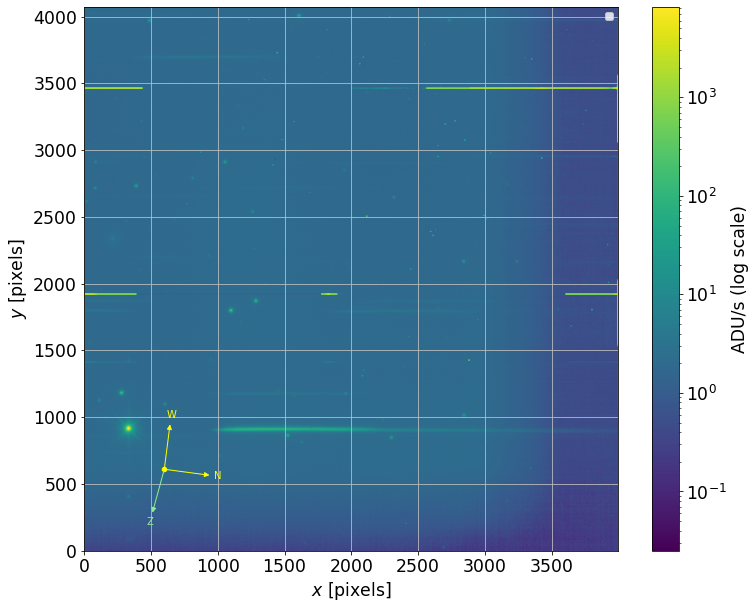

In [145]:
image.plot_image(figsize=(12, 10),scale="log")

In [146]:
filename_image

'Cor_holo4_003_empty_HD115169_20210608_000260.fits'

In [147]:
guess = [1500, 2300] # filename_image=df['file'][0] , 'Cor_holo4_003_RG610_HD105070_20210608_000223.fits'

#guess = [400, 800] # filename_image=df['file'][31] , Cor_holo4_003_empty_HD115169_20210608_000260.fits'


In [148]:
filename_image

'Cor_holo4_003_empty_HD115169_20210608_000260.fits'

2021-06-17 17:06:13  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                   c0_1         
    ----------------- ---------------------- ----------------------
    2.174231772223557 -0.0003418671401642499 0.00012757630549007547
2021-06-17 17:06:13  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                   c0_1         
    ----------------- ---------------------- ----------------------
    2.174231772223557 -0.0003418671401642499 0.00012757630549007547
2021-06-17 17:06:13  spectractor.fit.fitter gradient_descent     WARNING 
	Step 0: amplitude has a null Jacobian; parameter is fixed at its last known current value (-15.143366939061792).
2021-06-17 17:06:13  spectractor.fit.fitter gradient_descent    

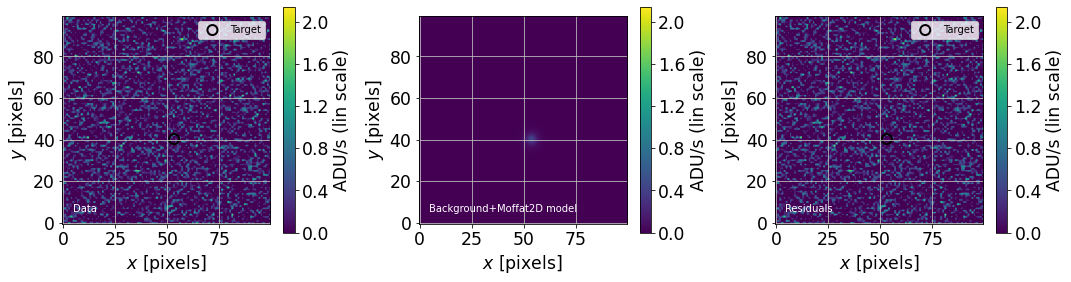

In [149]:

parameters.VERBOSE = True
parameters.DEBUG = True
x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)

In [150]:
print(x1,y1)

1492.2759655511024 2302.2180821563998


In [151]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [152]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [153]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [154]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [155]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [156]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [157]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [158]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [159]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [160]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [161]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [162]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [163]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

Text(0.05, 0.2, 'normal  : p_test   = 2.457e-02\n             : p_test_x = 6.695e-01\n             : p_test_y = 9.592e-01')

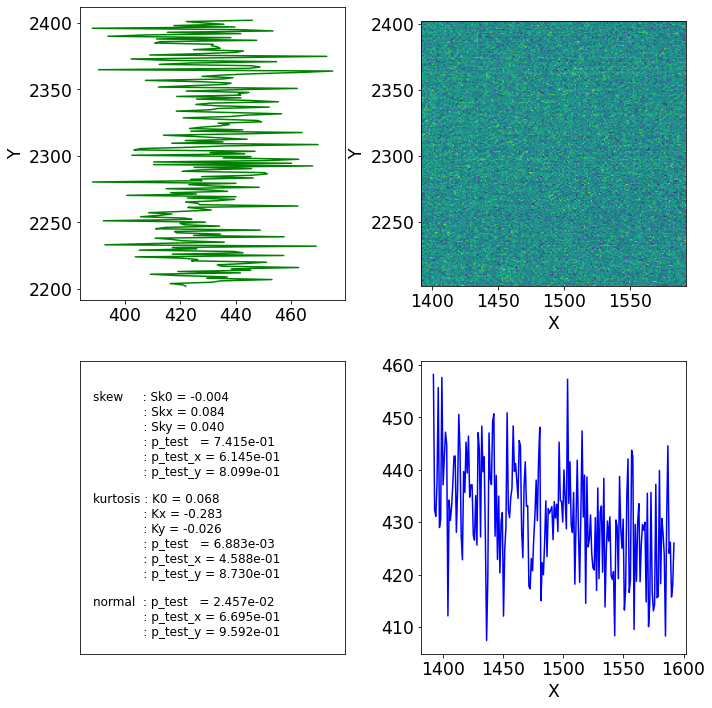

In [164]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)

# Go for spectrum reconstruction

2021-06-17 17:06:18  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-06-17 17:06:18  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> parameters.OBS_ALTITUDE: 2.66299616375123	 <class 'float'>
x obs_latitude: -30.2446389756252	=> parameters.OBS_LATITUDE: -30.2446389756252	 <class 'float'>
x obs_diameter: 1.20	=> parameters.OBS_DIAMETER: 1.2 m	 <class 'astropy.units.quantity.Quantity'>
x obs_epoch: J2000.0	=> parameters.OBS_EPOCH: J2000.0	 <class 'str'>
x obs_transmission_systematics: 0.005	=> parameters.OBS_TRANSMISSION_SYSTEMATICS: 0.005	 <c

2021-06-17 17:06:18  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-06-08/Cor_holo4_003_empty_HD115169_20210608_000260.fits...
2021-06-17 17:06:18  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-06-08/Cor_holo4_003_empty_HD115169_20210608_000260.fits...
2021-06-17 17:06:21  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-06-17 17:06:21  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-06-17 17:06:24  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-06-17 17:06:24  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-06-17 17:06:24  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-06-17 17:06:24  Hologram

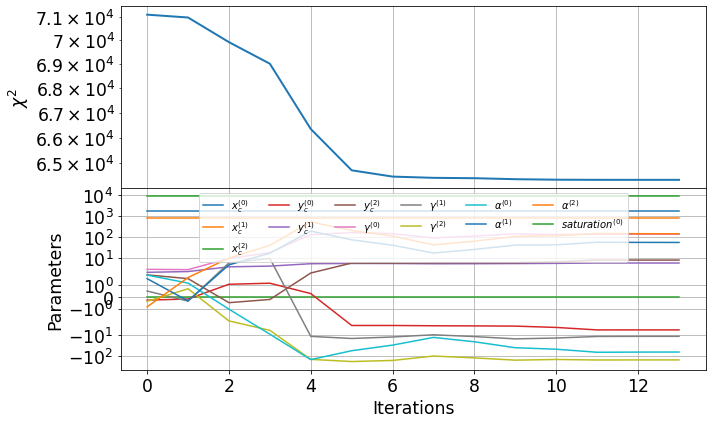

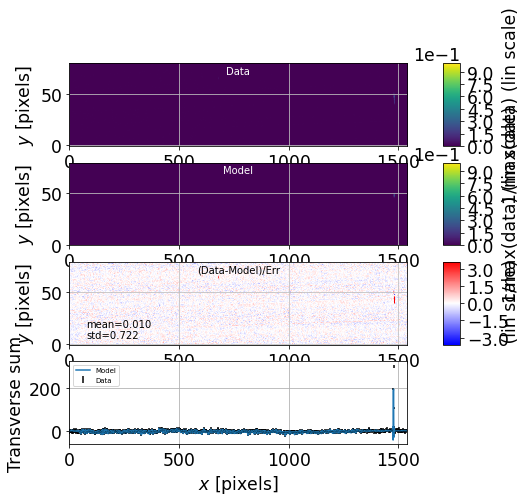

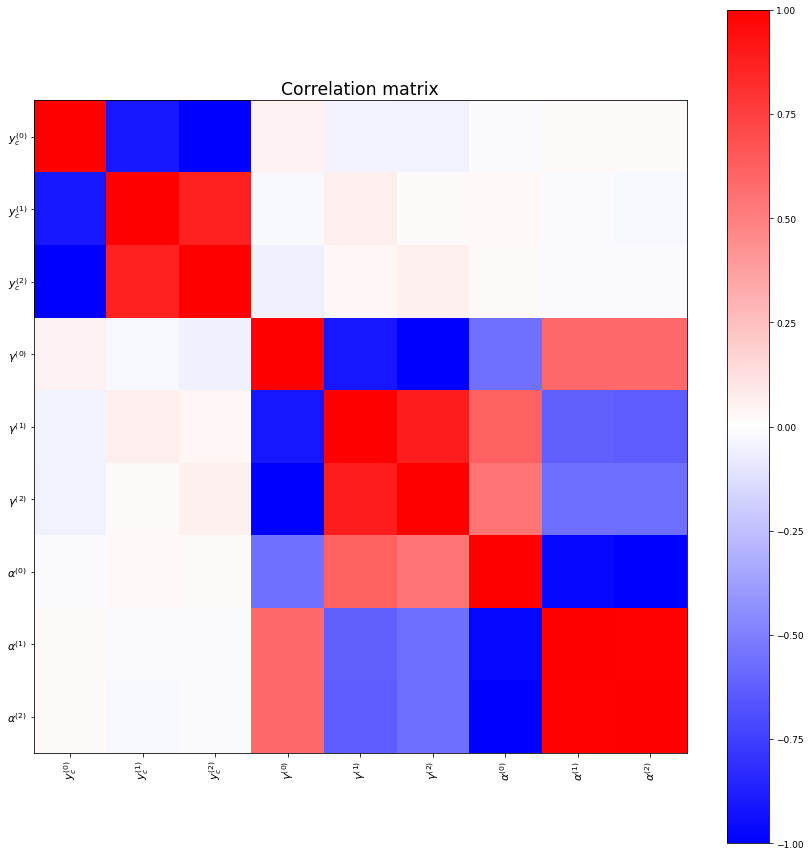

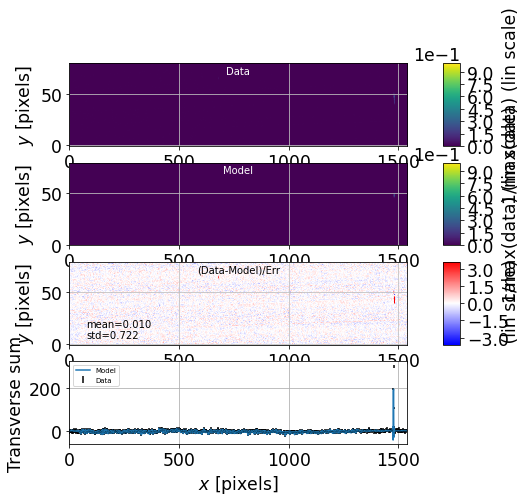

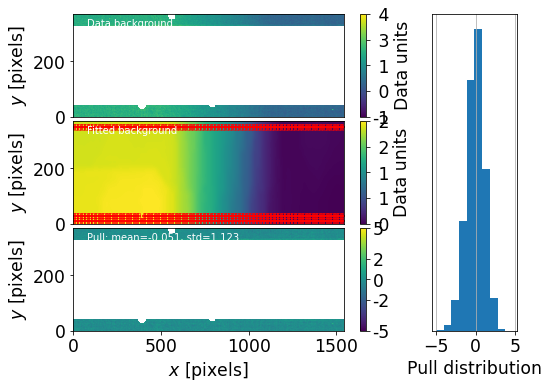

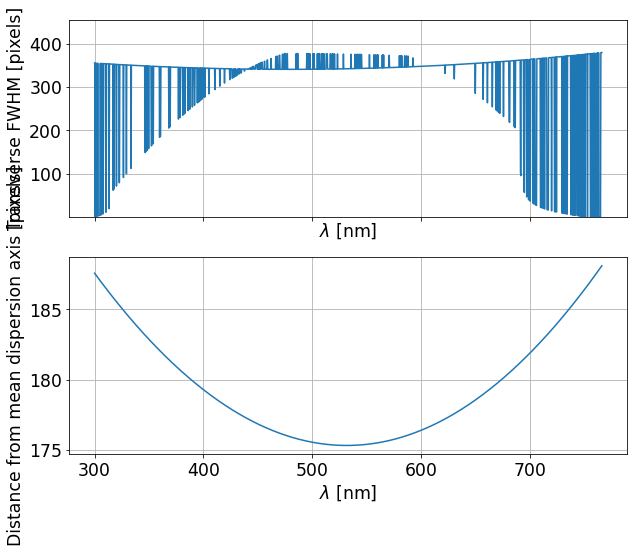

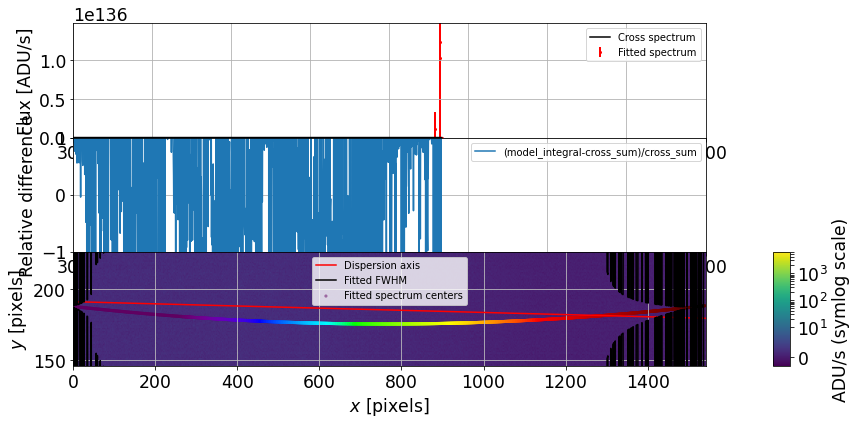

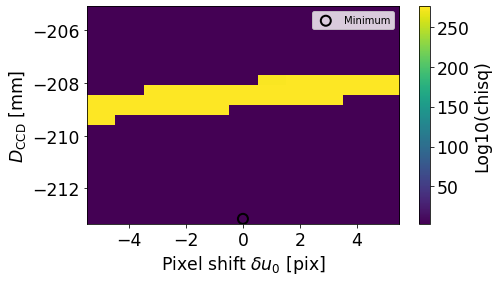

In [165]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

In [166]:
!jupyter labextension list


JupyterLab v2.2.6

Build recommended, please run `jupyter lab build`:
    @jupyterlab/debugger-extension needs to be included in build
    @jupyterlab/toc-extension needs to be included in build
    @jupyterlab/translation-extension needs to be included in build
    @jupyterlab/tabmanager-extension needs to be removed from build
    @jupyterlab/application changed from ~2.2.4 to ~3.0.7
    @jupyterlab/application-extension changed from ~2.2.4 to ~3.0.7
    @jupyterlab/apputils-extension changed from ~2.2.4 to ~3.0.7
    @jupyterlab/celltags-extension changed from ~2.2.4 to ~3.0.7
    @jupyterlab/codemirror-extension changed from ~2.2.4 to ~3.0.7
    @jupyterlab/completer-extension changed from ~2.2.4 to ~3.0.7
    @jupyterlab/console-extension changed from ~2.2.4 to ~3.0.7
    @jupyterlab/coreutils changed from ~4.2.3 to ~5.0.3
    @jupyterlab/csvviewer-extension changed from ~2.2.4 to ~3.0.7
    @jupyterlab/docmanager-extension changed from ~2.2.4 to ~3.0.7
    @jupyterlab/documentsea